<a href="https://colab.research.google.com/github/ckkissane/deep_learning_curriculum/blob/master/solutions/5_Modeling_Objectives.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train a contrastive CNN on MNIST. Hold out a few examples from each class from the training set. 

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [53]:
def set_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_seed(3407)

In [54]:
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.Compose([
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download=True)

In [55]:
# custom dataset to load pairs of examples
class MnistPairs(Dataset):
    def __init__(self, train=True):
        self.torch_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=train,
                                           transform=transforms.Compose([
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download=True)
        self.train_dataset, self.held_out = torch.utils.data.random_split(self.torch_dataset, [50000, 10000])
    
    def __len__(self):
        return len(self.train_dataset)
    
    def __getitem__(self, idx):
        x1, y1 = self.train_dataset[idx]
        # method to give matching pairs about half the time
        # potential TODO: speed this up with pre-processing
        same_class = random.randint(0, 1)
        if same_class:
            while True:
                x2, y2 = random.choice(self.train_dataset)
                if y2 == y1:
                    break
        else:
            while True:
                x2, y2 = random.choice(self.train_dataset)
                if y2 != y1:
                    break
        label = torch.tensor([y1 != y2], dtype=torch.float32)
        return (x1, y1, x2, y2, label)

In [56]:
# define CNN model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.linear_layers = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2),
        )
    
    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), kernel_size=2, stride=2)
        x = F.max_pool2d(self.conv2(x), kernel_size=2, stride=2)
        x = x.reshape(-1, 1024)
        x = self.linear_layers(x)
        return x

In [57]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super().__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [59]:
pair_dataset = MnistPairs(train=True)
pair_loader = DataLoader(pair_dataset, batch_size=128, shuffle=False)

In [60]:
model = CNN().to(device).train()
criterion = ContrastiveLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)

In [61]:
max_epochs = 10
losses = []
for epoch in range(max_epochs):
    pbar = tqdm(enumerate(pair_loader), total=len(pair_loader))
    for it, (x1, y1, x2, y2, label) in pbar:
        x1 = x1.to(device)
        out1 = model(x1)
    
        x2 = x2.to(device)
        out2 = model(x2)
    
        optimizer.zero_grad()
        label = label.to(device)
        loss = criterion(out1, out2, label)
    
        loss.backward()
        optimizer.step()
    
        losses.append(loss.item())
        pbar.set_description(f"epoch: {epoch}, loss: {loss.item():.5f}")

epoch: 9, loss: 0.27007: 100%|██████████| 391/391 [01:31<00:00,  4.27it/s]


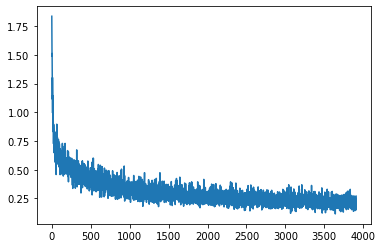

In [62]:
plt.plot(losses);
plt.show()

# Once your model has finished training, use your held-out examples to measure the classification accuracy of your model: for each test example, measure the similarity of the test example to each held-out example, and choose the class with the highest average similarity.

In [63]:
test_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=False,
                                           transform=transforms.Compose([
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download=True)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [64]:
held_out_imgs = []
for i in range(10):
    for img, label in pair_dataset.held_out:
        if label == i:
            held_out_imgs.append((img.unsqueeze(0).to(device), label))
            break

In [65]:
correct, total = 0, 0
for it, (x, y) in enumerate(test_loader):
    x = x.to(device)
    min_dist = float('inf')
    out1 = model(x)
    output_label = None
    for img, label in held_out_imgs:
        out2 = model(img)
        dist = torch.linalg.norm(out1 - out2, ord=2)
        if dist < min_dist:
            min_dist = dist
            output_label = label
    correct += (output_label == y).item()
    total += 1

print(f"accuracy: {correct / total}")

accuracy: 0.8155
